<a href="https://colab.research.google.com/github/NP-15/Machine-learning/blob/main/Sessions/Decision-Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ID3

In [9]:
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
import graphviz

In [8]:
!pip install graphviz

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Machine-learning-main/assets/tennis.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Wind         14 non-null     object
 4   Play         14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


In [5]:
# Calculating total entropy of the dataset
def calc_total_entropy(data, label, class_list):
    total_row = data.shape[0]
    total_entr = 0

    for c in class_list:
        total_class_count = data[data[label] == c].shape[0]
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row)
        total_entr += total_class_entr

    return total_entr

#Calculating individual feature entropy
def calc_feature_entropy(feature_info, label, class_list):
    class_count = feature_info.shape[0]
    entropy = 0

    for c in class_list:
        label_class_count = feature_info[feature_info[label] == c].shape[0]
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

#Calculating information gain
def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique()
    total_row = train_data.shape[0]
    feature_info = 0.0

    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value]
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_feature_entropy(feature_value_data, label, class_list)
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy

    return calc_total_entropy(train_data, label, class_list) - feature_info

#Finding correct node
def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label)
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain:
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature



In [6]:
# Creating the tree
def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False)
    tree = {}

    for feature_value, count in feature_value_count_dict.iteritems():
        feature_value_data = train_data[train_data[feature_name] == feature_value]

        assigned_to_node = False
        for c in class_list:
            class_count = feature_value_data[feature_value_data[label] == c].shape[0]
            if class_count == count:
                tree[feature_value] = c
                train_data = train_data[train_data[feature_name] != feature_value]
                assigned_to_node = True
        if not assigned_to_node:
            tree[feature_value] = "?"

    return tree, train_data

# ID3
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0:
        max_info_feature = find_most_informative_feature(train_data, label, class_list)
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list)
        next_root = None

        if prev_feature_value != None:
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else:
            root[max_info_feature] = tree
            next_root = root[max_info_feature]

        for node, branch in list(next_root.items()):
            if branch == "?":
                feature_value_data = train_data[train_data[max_info_feature] == node]
                make_tree(next_root, node, feature_value_data, label, class_list)

def id3(dataset, label):
    data = dataset.copy()
    tree = {}
    class_list = data[label].unique()
    make_tree(tree, None, data, label, class_list)
    return tree

#### Generating the tree

In [11]:
tree = id3(df, 'Play')

<ipython-input-6-769ff0160819>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-6-769ff0160819>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-6-769ff0160819>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():


In [16]:
import pydot
from IPython.display import display
from PIL import Image as PILImage

def visualize_tree(tree, parent_name=None, graph=None):
    if graph is None:
        graph = pydot.Dot()
        graph.set_node_defaults(shape='box', fontsize=10)
    for key, value in tree.items():
        if isinstance(value, dict):
            # Recursively visualize subtree
            child_node = pydot.Node(key, label=key)
            if parent_name:
                graph.add_node(child_node)
                graph.add_edge(pydot.Edge(parent_name, child_node))
            visualize_tree(value, parent_name=key, graph=graph)
        else:
            # Leaf node
            node_label = "{}: {}".format(key, value)
            leaf_node = pydot.Node(node_label, label=node_label)
            graph.add_node(leaf_node)
            if parent_name:
                graph.add_edge(pydot.Edge(parent_name, leaf_node))
    return graph

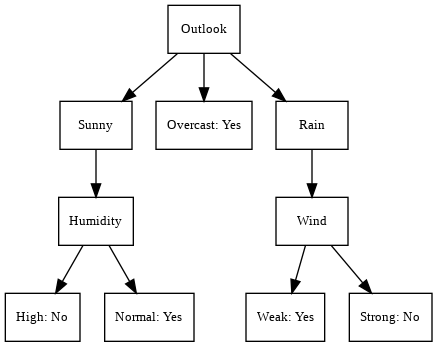

In [17]:
graph = visualize_tree(tree)

image_path = "/content/decision_tree.png"
graph.write_png(image_path)

display(PILImage.open(image_path))

# C4.5

In [ ]:
import pandas as pd
import numpy  as np
from random import randint
from scipy import stats
from copy import deepcopy

In [ ]:
def is_number(string):
    for i in range(0, len(string)):
        if pd.isnull(string[i]) == False:
            try:
                float(string[i])
                return True
            except ValueError:
                return False

def is_number_value(value):
    if pd.isnull(value) == False:
        try:
            float(value)
            return True
        except ValueError:
            return False

def chi_squared_test(label_df, feature_df):
    label_df.reset_index(drop=True, inplace=True)
    feature_df.reset_index(drop=True, inplace=True)
    data = pd.concat([pd.DataFrame(label_df.values.reshape((label_df.shape[0], 1))), feature_df], axis = 1)
    data.columns=["label", "feature"]
    contigency_table = pd.crosstab(data.iloc[:,0], data.iloc[:,1], margins = False)
    m = contigency_table.values.sum()
    if m <= 10000 and contigency_table.shape == (2,2):
        p_value = stats.fisher_exact(contigency_table)
    else:
        p_value = stats.chi2_contingency(contigency_table, correction = False) # (No Yates' Correction)
    return p_value[1]

def prediction_dt_c45(model, Xdata):
    Xdata = Xdata.reset_index(drop=True)
    ydata = pd.DataFrame(index=range(0, Xdata.shape[0]), columns=["Prediction"])
    data  = pd.concat([ydata, Xdata], axis = 1)
    rule = []

    for j in range(0, data.shape[1]):
        if data.iloc[:,j].dtype == "bool":
            data.iloc[:,j] = data.iloc[:, j].astype(str)

    dt_model = deepcopy(model)

    for i in range(0, len(dt_model)):
        dt_model[i] = dt_model[i].replace("{", "")
        dt_model[i] = dt_model[i].replace("}", "")
        dt_model[i] = dt_model[i].replace(";", "")
        dt_model[i] = dt_model[i].replace("IF ", "")
        dt_model[i] = dt_model[i].replace("AND", "")
        dt_model[i] = dt_model[i].replace("THEN", "")
        dt_model[i] = dt_model[i].replace("=", "")
        dt_model[i] = dt_model[i].replace("<", "<=")

    for i in range(0, len(dt_model) -2):
        splited_rule = [x for x in dt_model[i].split(" ") if x]
        rule.append(splited_rule)

    for i in range(0, Xdata.shape[0]):
        for j in range(0, len(rule)):
            rule_confirmation = len(rule[j])/2 - 1
            rule_count = 0
            for k in range(0, len(rule[j]) - 2, 2):
                if is_number_value(data[rule[j][k]][i]) == False:
                    if (data[rule[j][k]][i] in rule[j][k+1]):
                        rule_count = rule_count + 1
                        if (rule_count == rule_confirmation):
                            data.iloc[i,0] = rule[j][len(rule[j]) - 1]
                    else:
                        k = len(rule[j])
                elif is_number_value(data[rule[j][k]][i]) == True:
                     if rule[j][k+1].find("<=") == 0:
                         if data[rule[j][k]][i] <= float(rule[j][k+1].replace("<=", "")):
                             rule_count = rule_count + 1
                             if (rule_count == rule_confirmation):
                                 data.iloc[i,0] = rule[j][len(rule[j]) - 1]
                         else:
                             k = len(rule[j])
                     elif rule[j][k+1].find(">") == 0:
                         if data[rule[j][k]][i] > float(rule[j][k+1].replace(">", "")):
                             rule_count = rule_count + 1
                             if (rule_count == rule_confirmation):
                                 data.iloc[i,0] = rule[j][len(rule[j]) - 1]
                         else:
                             k = len(rule[j])

    for i in range(0, Xdata.shape[0]):
        if pd.isnull(data.iloc[i,0]):
            data.iloc[i,0] = dt_model[len(dt_model)-1]

    return data

In [ ]:
def info_gain_ratio(target, feature = [], uniques = []):
    entropy = 0
    denominator_1 = feature.count()
    data = pd.concat([pd.DataFrame(target.values.reshape((target.shape[0], 1))), feature], axis = 1)
    for entp in range(0, len(np.unique(target))):
        numerator_1 = data.iloc[:,0][(data.iloc[:,0] == np.unique(target)[entp])].count()
        if numerator_1 > 0:
            entropy = entropy - (numerator_1/denominator_1)* np.log2((numerator_1/denominator_1))
    info_gain = float(entropy)
    info_gain_r = 0
    intrinsic_v = 0
    for word in range(0, len(uniques)):
        denominator_2 = feature[(feature == uniques[word])].count()
        if denominator_2[0] > 0:
            intrinsic_v = intrinsic_v - (denominator_2/denominator_1)* np.log2((denominator_2/denominator_1))
        for lbl in range(0, len(np.unique(target))):
            numerator_2 = data.iloc[:,0][(data.iloc[:,0] == np.unique(target)[lbl]) & (data.iloc[:,1]  == uniques[word])].count()
            if numerator_2 > 0:
                info_gain = info_gain + (denominator_2/denominator_1)*(numerator_2/denominator_2)* np.log2((numerator_2/denominator_2))
    if intrinsic_v[0] > 0:
        info_gain_r = info_gain/intrinsic_v
    return float(info_gain_r)

def split_me(feature, split):
    result = pd.DataFrame(feature.values.reshape((feature.shape[0], 1)))
    for fill in range(0, len(feature)):
        result.iloc[fill,0] = feature.iloc[fill]
    lower = "<=" + str(split)
    upper = ">" + str(split)
    for convert in range(0, len(feature)):
        if float(feature.iloc[convert]) <= float(split):
            result.iloc[convert,0] = lower
        else:
            result.iloc[convert,0] = upper
    binary_split = []
    binary_split = [lower, upper]
    return result, binary_split

In [ ]:
def dt_c45(Xdata, ydata, cat_missing = "none", num_missing = "none", pre_pruning = "none", chi_lim = 0.1, min_lim = 5):
    ydata = ydata.apply(str)
    name  = ydata.name
    if (name is None):
        name  = 'class'
    ydata = pd.DataFrame(ydata.values.reshape((ydata.shape[0], 1)))
    for j in range(0, ydata.shape[1]):
        if ydata.iloc[:,j].dropna().value_counts().index.isin([0,1]).all():
            for i in range(0, ydata.shape[0]):
               if ydata.iloc[i,j] == 0:
                   ydata.iloc[i,j] = "zero"
               else:
                   ydata.iloc[i,j] = "one"
    dataset = pd.concat([ydata, Xdata], axis = 1)

    for j in range(0, dataset.shape[1]):
        if dataset.iloc[:,j].dtype == "bool":
            dataset.iloc[:,j] = dataset.iloc[:, j].astype(str)

    if cat_missing != "none":
        for j in range(1, dataset.shape[1]):
            if is_number(dataset.iloc[:, j]) == False:
                for i in range(0, dataset.shape[0]):
                    if pd.isnull(dataset.iloc[i,j]) == True:
                        if cat_missing == "missing":
                            dataset.iloc[i,j] = "Unknow"
                        elif cat_missing == "most":
                            dataset.iloc[i,j] = dataset.iloc[:,j].value_counts().idxmax()
                        elif cat_missing == "remove":
                            dataset = dataset.drop(dataset.index[i], axis = 0)
                        elif cat_missing == "probability":
                            while pd.isnull(dataset.iloc[i,j]) == True:
                                dataset.iloc[i,j] = dataset.iloc[randint(0, dataset.shape[0] - 1), j]
    elif num_missing != "none":
            if is_number(dataset.iloc[:, j]) == True:
                for i in range(0, dataset.shape[0]):
                    if pd.isnull(dataset.iloc[i,j]) == True:
                        if num_missing == "mean":
                            dataset.iloc[i,j] = dataset.iloc[:,j].mean()
                        elif num_missing == "median":
                            dataset.iloc[i,j] = dataset.iloc[:,j].median()
                        elif num_missing == "most":
                            dataset.iloc[i,j] = dataset.iloc[:,j].value_counts().idxmax()
                        elif cat_missing == "remove":
                            dataset = dataset.drop(dataset.index[i], axis = 0)
                        elif num_missing == "probability":
                            while pd.isnull(dataset.iloc[i,j]) == True:
                                dataset.iloc[i,j] = dataset.iloc[randint(0, dataset.shape[0] - 1), j]

    unique = []
    uniqueWords = []
    for j in range(0, dataset.shape[1]):
        for i in range(0, dataset.shape[0]):
            token = dataset.iloc[i, j]
            if not token in unique:
                unique.append(token)
        uniqueWords.append(unique)
        unique = []

    label = np.array(uniqueWords[0])
    label = label.reshape(1, len(uniqueWords[0]))

    i = 0
    impurity = 0
    branch = [None]*1
    branch[0] = dataset
    gain_ratio = np.empty([1, branch[i].shape[1]])
    lower = "0"
    root_index = 0
    rule = [None]*1
    rule[0] = "IF "
    skip_update = False
    stop = 2
    upper = "1"

    while (i < stop):
        impurity = np.amax(gain_ratio)
        gain_ratio.fill(0)
        for element in range(1, branch[i].shape[1]):
            if len(branch[i]) == 0:
                skip_update = True
                break
            if len(np.unique(branch[i][0])) == 1 or len(branch[i]) == 1:
                 if ";" not in rule[i]:
                     rule[i] = rule[i] + " THEN " + name + " = " + branch[i].iloc[0, 0] + ";"
                     rule[i] = rule[i].replace(" AND  THEN ", " THEN ")
                 skip_update = True
                 break
            if i > 0 and is_number(dataset.iloc[:, element]) == False and pre_pruning == "chi_2" and chi_squared_test(branch[i].iloc[:, 0], branch[i].iloc[:, element]) > chi_lim:
                 if ";" not in rule[i]:
                     rule[i] = rule[i] + " THEN " + name + " = " + branch[i].agg(lambda x:x.value_counts().index[0])[0] + ";"
                     rule[i] = rule[i].replace(" AND  THEN ", " THEN ")
                 skip_update = True
                 continue
            if is_number(dataset.iloc[:, element]) == True:
                gain_ratio[0, element] = 0.0
                value = np.sort(branch[i].iloc[:, element].unique())
                skip_update = False
                if branch[i][(branch[i].iloc[:, element] == value[0])].count()[0] > 1:
                    start = 0
                    finish = len(branch[i].iloc[:, element].unique()) - 2
                else:
                    start = 1
                    finish = len(branch[i].iloc[:, element].unique()) - 2
                if len(branch[i]) == 2 or len(value) == 1 or len(value) == 2:
                    start = 0
                    finish = 1
                if len(value) == 3:
                    start = 0
                    finish = 2
                for bin_split in range(start, finish):
                    bin_sample = split_me(feature = branch[i].iloc[:, element], split = value[bin_split])
                    if i > 0 and pre_pruning == "chi_2" and chi_squared_test(branch[i].iloc[:, 0], bin_sample[0]) > chi_lim:
                        if ";" not in rule[i]:
                             rule[i] = rule[i] + " THEN " + name + " = " + branch[i].agg(lambda x:x.value_counts().index[0])[0] + ";"
                             rule[i] = rule[i].replace(" AND  THEN ", " THEN ")
                        skip_update = True
                        continue
                    igr = info_gain_ratio(target = branch[i].iloc[:, 0], feature = bin_sample[0], uniques = bin_sample[1])
                    if igr > float(gain_ratio[0, element]):
                        gain_ratio[0, element] = igr
                        uniqueWords[element] = bin_sample[1]
            if is_number(dataset.iloc[:, element]) == False:
                gain_ratio[0, element] = 0.0
                skip_update = False
                igr = info_gain_ratio(target = branch[i].iloc[:, 0], feature =  pd.DataFrame(branch[i].iloc[:, element].values.reshape((branch[i].iloc[:, element].shape[0], 1))), uniques = uniqueWords[element])
                gain_ratio[0, element] = igr
            if i > 0 and pre_pruning == "min" and len(branch[i]) <= min_lim:
                 if ";" not in rule[i]:
                     rule[i] = rule[i] + " THEN " + name + " = " + branch[i].agg(lambda x:x.value_counts().index[0])[0] + ";"
                     rule[i] = rule[i].replace(" AND  THEN ", " THEN ")
                 skip_update = True
                 continue

        if i > 0 and pre_pruning == "impur" and np.amax(gain_ratio) < impurity and np.amax(gain_ratio) > 0:
             if ";" not in rule[i]:
                 rule[i] = rule[i] + " THEN " + name + " = " + branch[i].agg(lambda x:x.value_counts().index[0])[0] + ";"
                 rule[i] = rule[i].replace(" AND  THEN ", " THEN ")
             skip_update = True
             continue

        if skip_update == False:
            root_index = np.argmax(gain_ratio)
            rule[i] = rule[i] + str(list(branch[i])[root_index])

            for word in range(0, len(uniqueWords[root_index])):
                uw = uniqueWords[root_index][word].replace("<=", "")
                uw = uw.replace(">", "")
                lower = "<=" + uw
                upper = ">" + uw
                if uniqueWords[root_index][word] == lower:
                    branch.append(branch[i][branch[i].iloc[:, root_index] <= float(uw)])
                elif uniqueWords[root_index][word] == upper:
                    branch.append(branch[i][branch[i].iloc[:, root_index]  > float(uw)])
                else:
                    branch.append(branch[i][branch[i].iloc[:, root_index] == uniqueWords[root_index][word]])

                rule.append(rule[i] + " = " + "{" + uniqueWords[root_index][word] + "}")

            for logic_connection in range(1, len(rule)):
                if len(np.unique(branch[i][0])) != 1 and rule[logic_connection].endswith(" AND ") == False  and rule[logic_connection].endswith("}") == True:
                    rule[logic_connection] = rule[logic_connection] + " AND "
        skip_update = False
        i = i + 1
        stop = len(rule)

    for i in range(len(rule) - 1, -1, -1):
        if rule[i].endswith(";") == False:
            del rule[i]

    rule.append("Total Number of Rules: " + str(len(rule)))
    rule.append(dataset.agg(lambda x:x.value_counts().index[0])[0])

    return rule

In [ ]:
df = pd.read_csv('/assets/tennis.csv')

X = df.iloc[:, 0:4]
y = df.iloc[:, 4]

dt_model = dt_c45(Xdata = X, ydata = y, cat_missing = "missing", num_missing = "mean", pre_pruning = "impur", chi_lim = 0.1, min_lim = 5)

test =  df.iloc[0:2, 0:4]
prediction_dt_c45(dt_model, test)

,Prediction,Outlook,Temperature,Humidity,Wind
0,No,Sunny,Hot,High,Weak
1,No,Sunny,Hot,High,Strong


# CART

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

df = pd.read_csv("/assets/tennis.csv")

# Conversion Table
conversions = {
    "Outlook" : {
        "Sunny" : 0,
        "Overcast" : 1,
        "Rain" : 2
    },
    "Temperature" : {
        "Hot" : 0,
        "Mild" : 1,
        "Cool" : 2
    },
    "Humidity" : {
        "High" : 0,
        "Low" : 1
    },
    "Wind" : {
        "Weak" : 0,
        "Strong" : 1
    },
    "Play" : {
        "No" : 0,
        "Yes" : 1
    }
}

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
X = df.iloc[:, 0:4]
y = df.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))